# DeepSolar Modeling

## Introduction

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
import time
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import re
from scipy.stats import pearsonr
import math
from statistics import median
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, accuracy_score
import shap
plt.style.use('ggplot')
pd.options.mode.chained_assignment = None  # default='warn'

/Users/nick/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Load in the data
data = pd.read_csv("/Users/nick/Desktop/PythonData/deepsolar/deepsolar_tract.csv", engine='python')


In [3]:
# data.info

In [4]:
print ('The data has {} rows and {} columns'.format(data.shape[0],data.shape[1]))


The data has 72537 rows and 169 columns


In [5]:
data.head(10)

,Unnamed: 0,tile_count,solar_system_count,total_panel_area,fips,average_household_income,county,education_bachelor,education_college,education_doctoral,...,incentive_count_nonresidential,incentive_residential_state_level,incentive_nonresidential_state_level,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate
0,0,0.0,0.0,0.000000,27145011200,70352.789869,Stearns County,569,1690,13,...,39,11,13,34,0,0,25,12,0,9.46
1,1,25.0,21.0,1133.436461,27145011301,61727.085202,Stearns County,674,1434,108,...,39,11,13,34,0,0,25,12,0,9.46
2,2,3.0,3.0,64.505776,27145011302,71496.886583,Stearns County,854,1459,31,...,39,11,13,34,0,0,25,12,0,9.46
3,3,0.0,0.0,0.000000,27145011304,86840.152755,Stearns County,640,1116,68,...,39,11,13,34,0,0,25,12,0,9.46
4,4,5.0,5.0,164.583303,27145011400,89135.315597,Stearns County,654,1314,15,...,39,11,13,34,0,0,25,12,0,9.46
5,5,0.0,0.0,0.000000,27145011500,62225.903614,Stearns County,522,1395,24,...,39,11,13,34,0,0,25,12,0,9.46
6,6,2.0,2.0,25.299013,27145011600,41068.936170,Stearns County,49,278,32,...,39,11,13,34,0,0,25,12,0,9.46
7,7,0.0,0.0,0.000000,27145010500,74073.833671,Stearns County,242,867,10,...,39,11,13,34,0,0,25,12,0,9.46
8,8,0.0,0.0,0.000000,27145011100,69412.192435,Stearns County,527,1665,6,...,39,11,13,34,0,0,25,12,0,9.46
9,9,11.0,10.0,415.365350,27145010102,82502.407069,Stearns County,1582,1949,6,...,39,11,13,34,0,0,25,12,0,9.46


In [6]:
print("Dataset missing values:\n", data.isna().sum())
data.fillna(0)

Dataset missing values:
 Unnamed: 0                     0
tile_count                     0
solar_system_count             0
total_panel_area               0
fips                           0
                              ..
cooperate_tax                  0
property_tax                   0
sales_tax                      0
rebate                         0
avg_electricity_retail_rate    0
Length: 169, dtype: int64


,Unnamed: 0,tile_count,solar_system_count,total_panel_area,fips,average_household_income,county,education_bachelor,education_college,education_doctoral,...,incentive_count_nonresidential,incentive_residential_state_level,incentive_nonresidential_state_level,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate
0,0,0.0,0.0,0.000000,27145011200,70352.789869,Stearns County,569,1690,13,...,39,11,13,34,0,0,25,12,0,9.46
1,1,25.0,21.0,1133.436461,27145011301,61727.085202,Stearns County,674,1434,108,...,39,11,13,34,0,0,25,12,0,9.46
2,2,3.0,3.0,64.505776,27145011302,71496.886583,Stearns County,854,1459,31,...,39,11,13,34,0,0,25,12,0,9.46
3,3,0.0,0.0,0.000000,27145011304,86840.152755,Stearns County,640,1116,68,...,39,11,13,34,0,0,25,12,0,9.46
4,4,5.0,5.0,164.583303,27145011400,89135.315597,Stearns County,654,1314,15,...,39,11,13,34,0,0,25,12,0,9.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72532,72533,1.0,1.0,40.277124,8049000202,90163.611860,Grand County,1612,1419,3,...,50,12,15,11,0,0,10,11,0,9.82
72533,72534,0.0,0.0,0.000000,40085094100,45124.153006,Love County,95,441,0,...,19,1,7,19,0,0,0,0,0,7.86
72534,72535,1.0,1.0,21.902255,40085094200,60878.458738,Love County,426,961,11,...,19,1,7,19,0,0,0,0,0,7.86
72535,72536,0.0,0.0,0.000000,40085094300,56817.996870,Love County,134,355,5,...,19,1,7,19,0,0,0,0,0,7.86


In [7]:
cols = data.columns.tolist()
print(cols)


['Unnamed: 0', 'tile_count', 'solar_system_count', 'total_panel_area', 'fips', 'average_household_income', 'county', 'education_bachelor', 'education_college', 'education_doctoral', 'education_high_school_graduate', 'education_less_than_high_school', 'education_master', 'education_population', 'education_professional_school', 'employed', 'gini_index', 'heating_fuel_coal_coke', 'heating_fuel_electricity', 'heating_fuel_fuel_oil_kerosene', 'heating_fuel_gas', 'heating_fuel_housing_unit_count', 'heating_fuel_none', 'heating_fuel_other', 'heating_fuel_solar', 'land_area', 'per_capita_income', 'population', 'population_density', 'poverty_family_below_poverty_level', 'poverty_family_count', 'race_asian', 'race_black_africa', 'race_indian_alaska', 'race_islander', 'race_other', 'race_two_more', 'race_white', 'state', 'total_area', 'unemployed', 'water_area', 'education_less_than_high_school_rate', 'education_high_school_graduate_rate', 'education_college_rate', 'education_bachelor_rate', 'edu

In [44]:
# Feature separation
all_data_features = ['tile_count', 'solar_system_count', 'total_panel_area', 'fips', 'average_household_income', 'education_bachelor', 'education_college', 'education_doctoral', 'education_high_school_graduate', 'education_less_than_high_school', 'education_master', 'education_population', 'education_professional_school', 'employed', 'gini_index', 'heating_fuel_coal_coke', 'heating_fuel_electricity', 'heating_fuel_fuel_oil_kerosene', 'heating_fuel_gas', 'heating_fuel_housing_unit_count', 'heating_fuel_none', 'heating_fuel_other', 'heating_fuel_solar', 'land_area', 'per_capita_income', 'population', 'population_density', 'poverty_family_below_poverty_level', 'poverty_family_count', 'race_asian', 'race_black_africa', 'race_indian_alaska', 'race_islander', 'race_other', 'race_two_more', 'race_white', 'total_area', 'unemployed', 'water_area', 'education_less_than_high_school_rate', 'education_high_school_graduate_rate', 'education_college_rate', 'education_bachelor_rate', 'education_master_rate', 'education_professional_school_rate', 'education_doctoral_rate', 'race_white_rate', 'race_black_africa_rate', 'race_indian_alaska_rate', 'race_asian_rate', 'race_islander_rate', 'race_other_rate', 'race_two_more_rate', 'employ_rate', 'poverty_family_below_poverty_level_rate', 'heating_fuel_gas_rate', 'heating_fuel_electricity_rate', 'heating_fuel_fuel_oil_kerosene_rate', 'heating_fuel_coal_coke_rate', 'heating_fuel_solar_rate', 'heating_fuel_other_rate', 'heating_fuel_none_rate', 'solar_panel_area_divided_by_area', 'solar_panel_area_per_capita', 'tile_count_residential', 'tile_count_nonresidential', 'solar_system_count_residential', 'solar_system_count_nonresidential', 'total_panel_area_residential', 'total_panel_area_nonresidential', 'median_household_income', 'electricity_price_residential', 'electricity_price_commercial', 'electricity_price_industrial', 'electricity_price_transportation', 'electricity_price_overall', 'electricity_consume_residential', 'electricity_consume_commercial', 'electricity_consume_industrial', 'electricity_consume_total', 'household_count', 'average_household_size', 'housing_unit_count', 'housing_unit_occupied_count', 'housing_unit_median_value', 'housing_unit_median_gross_rent', 'lat', 'lon', 'elevation', 'heating_design_temperature', 'cooling_design_temperature', 'earth_temperature_amplitude', 'frost_days', 'air_temperature', 'relative_humidity', 'daily_solar_radiation', 'atmospheric_pressure', 'wind_speed', 'earth_temperature', 'heating_degree_days', 'cooling_degree_days', 'age_18_24_rate', 'age_25_34_rate', 'age_more_than_85_rate', 'age_75_84_rate', 'age_35_44_rate', 'age_45_54_rate', 'age_65_74_rate', 'age_55_64_rate', 'age_10_14_rate', 'age_15_17_rate', 'age_5_9_rate', 'household_type_family_rate', 'dropout_16_19_inschool_rate', 'occupation_construction_rate', 'occupation_public_rate', 'occupation_information_rate', 'occupation_finance_rate', 'occupation_education_rate', 'occupation_administrative_rate', 'occupation_manufacturing_rate', 'occupation_wholesale_rate', 'occupation_retail_rate', 'occupation_transportation_rate', 'occupation_arts_rate', 'occupation_agriculture_rate', 'occupancy_vacant_rate', 'occupancy_owner_rate', 'mortgage_with_rate', 'transportation_home_rate', 'transportation_car_alone_rate', 'transportation_walk_rate', 'transportation_carpool_rate', 'transportation_motorcycle_rate', 'transportation_bicycle_rate', 'transportation_public_rate', 'travel_time_less_than_10_rate', 'travel_time_10_19_rate', 'travel_time_20_29_rate', 'travel_time_30_39_rate', 'travel_time_40_59_rate', 'travel_time_60_89_rate', 'health_insurance_public_rate', 'health_insurance_none_rate', 'age_median', 'travel_time_average', 'voting_2016_dem_percentage', 'voting_2016_gop_percentage', 'voting_2012_dem_percentage', 'voting_2012_gop_percentage', 'number_of_years_of_education', 'diversity', 'number_of_solar_system_per_household', 'incentive_count_residential', 'incentive_count_nonresidential', 'incentive_residential_state_level', 'incentive_nonresidential_state_level', 'net_metering', 'feedin_tariff', 'cooperate_tax', 'property_tax', 'sales_tax', 'rebate', 'avg_electricity_retail_rate']
data_features = ['heating_fuel_coal_coke', 'heating_fuel_electricity', 'heating_fuel_fuel_oil_kerosene', 'heating_fuel_gas', 'heating_fuel_housing_unit_count', 'heating_fuel_none', 'heating_fuel_other', 'heating_fuel_solar''electricity_consume_residential', 'electricity_consume_commercial', 'electricity_consume_industrial', 'electricity_consume_total']
cols_to_drop = ['Unnamed: 0', 'state', 'county', 'voting_2016_dem_win', 'voting_2012_dem_win']


In [45]:
data[data_features].head(10)

,heating_fuel_coal_coke,heating_fuel_electricity,heating_fuel_fuel_oil_kerosene,heating_fuel_gas,heating_fuel_housing_unit_count,heating_fuel_none,heating_fuel_other,heating_fuel_solar,electricity_consume_residential,electricity_consume_commercial,electricity_consume_industrial,electricity_consume_total
0,200,448,98,1720,2527,10,51,0,762,6743,182201,189706
1,20,379,17,1799,2230,0,15,0,762,6743,182201,189706
2,69,440,45,2098,2698,29,17,0,762,6743,182201,189706
3,188,442,61,1113,1833,13,16,0,762,6743,182201,189706
4,96,497,47,1202,1917,31,44,0,762,6743,182201,189706
5,72,759,81,1695,2656,45,4,0,762,6743,182201,189706
6,3,222,5,193,470,16,31,0,762,6743,182201,189706
7,108,382,190,783,1479,3,13,0,762,6743,182201,189706
8,241,534,156,1735,2723,20,37,0,762,6743,182201,189706
9,18,734,27,2419,3282,29,55,0,762,6743,182201,189706


## Exploratory Data Analysis

## Feature Engineering

## Modeling

In [46]:
# Set up our X and y
X = data[data_features]
y = data['avg_electricity_retail_rate']

In [47]:
# Create a 80/20 stratified split of the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)

In [48]:
# Ensure the dimensions are correct
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (58029, 12) (58029,)
Test set: (14508, 12) (14508,)


In [53]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_root_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(X_test_data)
    else:
        pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [54]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Average Error: {:0.4f}'.format(np.mean(errors)))
    print('Accuracy = {:0.3f}%'.format(accuracy))
    
    return accuracy

In [55]:
def metrics(y_pred, y_test):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    errors = abs(y_pred - y_test)
    mae = np.mean(errors)
    mape = 100 * (errors / y_test)
    print('Mean Squared Error: ', round(mse, 4))
    print('Root Mean Squared Error: ', round(rmse, 4))
    print('Mean Absolute Error: ', round(mae, 4))

    
    # Calculate and display accuracy
    test_accuracy = 100 - np.mean(mape)
    print('Test Set Accuracy (from Mean Absolute Percentage Error):{:.3f}%'.format(test_accuracy))

### Random Forest

#### Baseline

In [62]:
rfr_base_model = RandomForestRegressor(random_state=42)
rfr_base_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [63]:
y_pred = rfr_base_model.predict(X_test)

In [64]:
errors = abs(np.expm1(y_pred) - np.expm1(y_test.values))
# Print out the mean absolute error (mae)
print('Average Error:', round(np.mean(errors), 2))

Average Error: 0.07


In [65]:
print('Random Forest Baseline Model Metrics:')
metrics(y_pred, y_test.values)

Random Forest Baseline Model Metrics:
Mean Squared Error:  0.0
Root Mean Squared Error:  0.0005
Mean Absolute Error:  0.0
Test Set Accuracy (from Mean Absolute Percentage Error):100.000%


#### Hyperparameter Grid

In [66]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 25, 30],
    'max_features': [.4, 'auto'],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [1, 3, 5],
    'n_estimators': [100,400]
}

# Create a based model
rfr = RandomForestRegressor(random_state=42)
# Instantiate the grid search model
rfr, pred = algorithm_pipeline(X_train, X_test, y_train.values.ravel(), y_test.values, rfr, 
                                 param_grid, cv=5)

# Root Mean Squared Error
print(np.sqrt(-rfr.best_score_))
print(rfr.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 27.0min finished


0.05462744616329746
{'bootstrap': True, 'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 400}


In [67]:
print('Base Model:')
base_accuracy = evaluate(rfr_base_model, X_test, y_test.values)
print()
print('Model after Tuning:')
rfr_best_model = rfr.best_estimator_
best_accuracy = evaluate(rfr_best_model, X_test, y_test.values)

print('Improvement of {:0.2f}%.'.format( 100 * (best_accuracy - base_accuracy) / base_accuracy))

Base Model:
Average Error: 0.0000
Accuracy = 100.000%

Model after Tuning:
Average Error: 0.0000
Accuracy = 100.000%
Improvement of -0.00%.


In [68]:
y_pred = rfr_best_model.predict(X_test)
print('Random Forest Model (After Tuning) Metrics:')
metrics(y_pred, y_test.values)

Random Forest Model (After Tuning) Metrics:
Mean Squared Error:  0.0
Root Mean Squared Error:  0.0008
Mean Absolute Error:  0.0
Test Set Accuracy (from Mean Absolute Percentage Error):100.000%


#### Feature Importance

In [70]:
feature_importances = rfr_best_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], feature_importances[indices[f]]))

Feature ranking:
1. electricity_consume_residential (0.824210)
2. electricity_consume_industrial (0.072699)
3. electricity_consume_total (0.065636)
4. electricity_consume_commercial (0.032555)
5. heating_fuel_gas (0.004899)
6. heating_fuel_coal_coke (0.000000)
7. heating_fuel_housing_unit_count (0.000000)
8. heating_fuel_electricity (0.000000)
9. heating_fuel_other (0.000000)
10. heating_fuel_fuel_oil_kerosene (0.000000)


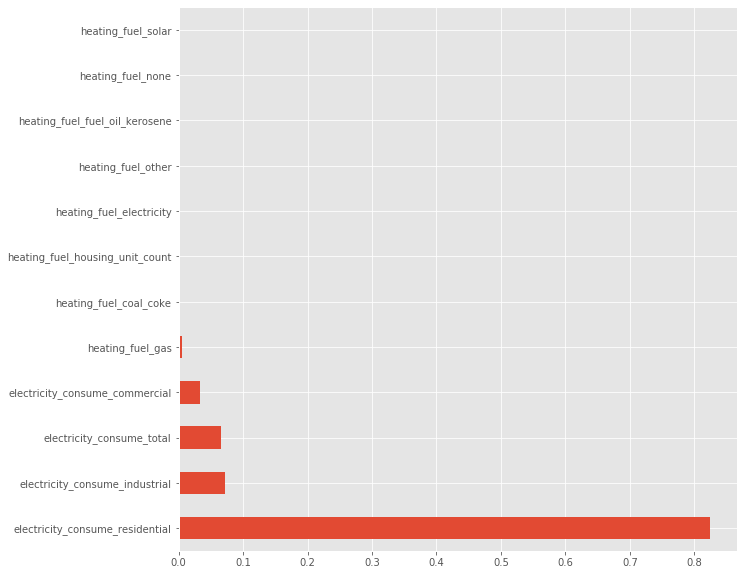

In [71]:
feat_importances = pd.Series(feature_importances, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', figsize=[10,10])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


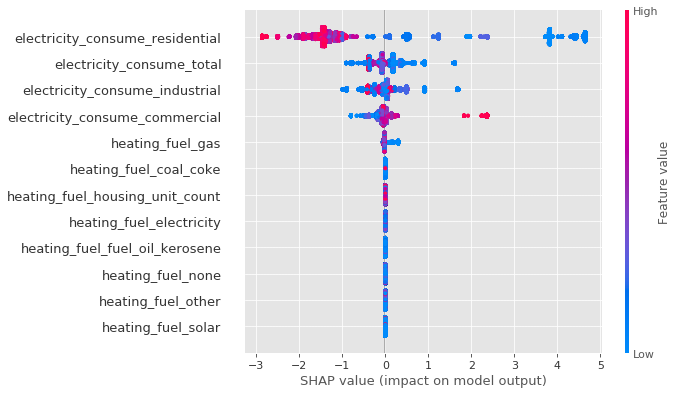

In [72]:
explainer = shap.TreeExplainer(rfr_best_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)